# Chap3 from the book: 'L'apprentissage profond avec Pyhton', François CHOLLET

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras.datasets import boston_housing
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# With Keras

In [12]:
physical_devices = tf.config.list_physical_devices('GPU')
gpu = physical_devices[0]
gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [13]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [14]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [15]:
std = train_data.std(axis=0)
train_data /= std

In [16]:
mean = train_data.mean(axis=0)
train_data -= mean

In [17]:
test_data -= mean
test_data /= std

In [18]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                896       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(
    loss='mse',
    metrics=['mae'],
    optimizer='rmsprop'
)

In [20]:
# K folds
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_history = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis=0)

    history = model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        validation_data=(val_data, val_targets)
        
    )
    mae_history = history.history['val_mae']

    all_mae_history.append(mae_history)



processing fold # 0
Epoch 1/500
10/10 [==============================] - 0s 22ms/step - loss: 547.5502 - mae: 21.5508 - val_loss: 492.0973 - val_mae: 19.7738
Epoch 2/500
10/10 [==============================] - 0s 12ms/step - loss: 484.5757 - mae: 19.9718 - val_loss: 428.9783 - val_mae: 18.0939
Epoch 3/500
10/10 [==============================] - 0s 12ms/step - loss: 419.3969 - mae: 18.2889 - val_loss: 360.2630 - val_mae: 16.2538
Epoch 4/500
10/10 [==============================] - 0s 12ms/step - loss: 348.9163 - mae: 16.4061 - val_loss: 289.2163 - val_mae: 14.2652
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 278.7095 - mae: 14.4143 - val_loss: 218.3487 - val_mae: 12.1227
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 209.6590 - mae: 12.2386 - val_loss: 154.2871 - val_mae: 9.9891
Epoch 7/500
10/10 [==============================] - 0s 8ms/step - loss: 148.7159 - mae: 9.9554 - val_loss: 102.0672 - val_mae: 7.9069
Epoch 8/500
10/10 [

In [21]:
len(all_mae_history[0])

500

In [22]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

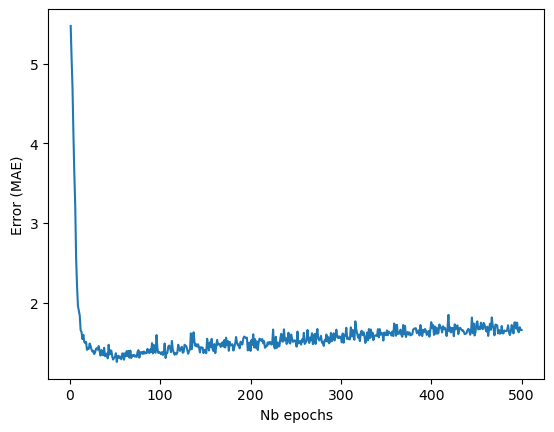

In [23]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Nb epochs')
plt.ylabel('Error (MAE)')
plt.show()

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

Text(0, 0.5, 'Error (MAE)')

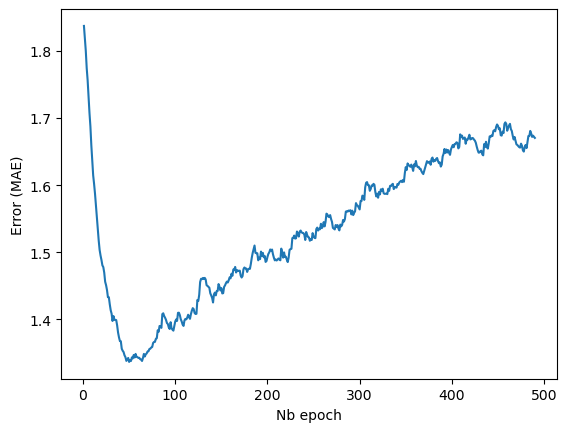

In [25]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Nb epoch')
plt.ylabel('Error (MAE)')

In [26]:
model.fit(
    train_data,
    train_targets,
    epochs=80,
    batch_size=16,
    verbose=0
)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 148311.4375 - mae: 384.9226


# With pyTorch

In [27]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data = torch.tensor(train_data, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32).unsqueeze(1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [28]:
def get_val_data_targets(num_val_samples: float, fold_nb: int, train_data: torch.Tensor, train_targets: torch.Tensor):
    val_data = train_data[fold_nb * num_val_samples: (fold_nb+1) * num_val_samples]
    val_targets = train_targets[fold_nb * num_val_samples: (fold_nb+1) * num_val_samples]
    val_dataset = TensorDataset(val_data, val_targets)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_data, val_targets, val_loader

In [29]:
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.layers1 = nn.Linear(input_size, 64)
        self.layers2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layers1(x))
        x = self.relu(self.layers2(x))
        x = self.output_layer(x)
        return x

In [30]:
def mae(output, target):
    return torch.mean(torch.abs(output - target))

In [35]:
k = 4
num_epochs = 500
all_mae_history = []
num_val_samples = len(train_data) // k
for i in range(k):
    print("processing fold #", i)
    val_data, val_targets, val_loader = get_val_data_targets(
        num_val_samples=num_val_samples,
        fold_nb=i,
        train_data=train_data,
        train_targets=train_targets
    )

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0
    )

    input_size = train_data.shape[1]
    model = SimpleModel(input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    val_mae = []
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        model.eval()
        mae = 0
        with torch.no_grad():
            for val_data, val_target in val_loader:
                val_output = model(val_data)
                mae += torch.abs(val_output - val_target).mean().item()
        mae /= len(val_loader)

        val_mae.append(mae)

    all_mae_history.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


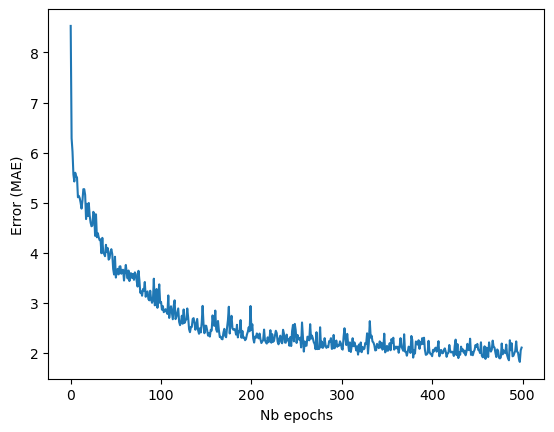

In [36]:
# all_mae_history
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

plt.plot(range(len(average_mae_history)), average_mae_history)
plt.xlabel('Nb epochs')
plt.ylabel('Error (MAE)')
plt.show()

Text(0, 0.5, 'Error (MAE)')

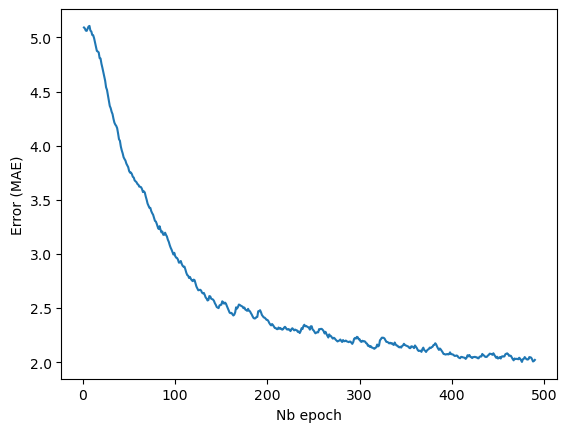

In [37]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Nb epoch')
plt.ylabel('Error (MAE)')